In [29]:
# Imports
# install it if you do not have
# pip install kagglehub
import kagglehub
import os, shutil


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier


In [30]:
# Download latest version
csv_name = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
path_download = kagglehub.dataset_download("blastchar/telco-customer-churn",force_download=True)
file_download = os.path.join(path_download, csv_name)

#-------------------------------------------------------------------------------------------------------
# Instead of saving to Google Drive directly, let's save to a local Colab directory first
#-------------------------------------------------------------------------------------------------------
path_destination = "dataset"
file_destination = os.path.join(path_destination, csv_name)

os.makedirs(path_destination,exist_ok=True)

# Check if the destination file already exists
if os.path.exists(file_destination):
    os.remove(file_destination)

# Use shutil.copyfile instead of shutil.move because the source is on a read-only file system
shutil.copyfile(file_download,file_destination)

df_rawtelco = pd.read_csv(file_destination)

pd.options.display.max_columns = None
df_rawtelco.head()

100%|██████████| 172k/172k [00:00<00:00, 1.07MB/s]

Extracting files...


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [31]:
## Exploring and understanding the data ##

print("Shape:",df_rawtelco.shape)
df_rawtelco.info()

Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

In [32]:
## target distribution

df_rawtelco["Churn"].value_counts(normalize=True) * 100

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

In [33]:
df_rawtelco.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [34]:
## missing values

df_rawtelco.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [35]:
## Data cleaning

## keep the original data
df_cleantelco = df_rawtelco.copy(deep = True)

## Total charges - Replace spaces with np.nan and converto to numeric datatype.

df_cleantelco["TotalCharges"] = df_cleantelco["TotalCharges"].replace(" ",np.nan )
df_cleantelco["TotalCharges"] = pd.to_numeric(df_cleantelco["TotalCharges"])

df_cleantelco["TotalCharges"].isna().sum()

11

In [36]:
## delete rows with totalchages null - small number of rows (11 only)

df_cleantelco = df_cleantelco.dropna(subset = ["TotalCharges"])
df_cleantelco.shape


(7032, 21)

In [37]:
# drop column customerid
df_cleantelco = df_cleantelco.drop(columns=["customerID"])

# convert Churn to binary
df_cleantelco["Churn"] = df_cleantelco["Churn"].map({"Yes":1, "No":0})

df_cleantelco["Churn"].value_counts()


Churn
0    5163
1    1869
Name: count, dtype: int64

In [38]:
cols_to_simplify = [
    "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

for col in cols_to_simplify:
    df_cleantelco[col] = df_cleantelco[col].replace({"No internet service": "No"})

# For phone service columns
df_cleantelco["MultipleLines"] = df_cleantelco["MultipleLines"].replace({"No phone service": "No"})

In [39]:
df_cleantelco.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0
7,Female,0,No,No,10,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,0
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


### **Encode Categorical Features:**
Generally, it is required to apply One-Hot Encoding (or another suitable encoding) to the categorical features before applying machine learning models like Logistic Regression, Random Forest Classifier, and Gradient Boost. Here's why:

*   **Logistic Regression:** This is a linear model and requires numerical input. Categorical variables must be converted into a numerical format for the model to process them correctly.

*   **Random Forest Classifier:** While tree-based models can sometimes implicitly handle categorical data, many implementations (including scikit-learn's Random Forest) still expect numerical input. One-Hot Encoding prevents the model from assuming an ordinal relationship between categories.
*   **Gradient Boost (e.g., XGBoost, LightGBM):** Similar to Random Forest, these models often perform best or require numerical input. Some advanced Gradient Boosting libraries like CatBoost can handle categorical features natively, but for more common implementations like XGBoost or LightGBM, encoding is usually necessary.

One-Hot Encoding creates new binary (0 or 1) columns for each category, which is a robust way to represent nominal categorical data without implying any false ordinality.

In [40]:
# Binning

dep_var = ['Churn']

categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']

Numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']


In [41]:
# Categorical variable - we will examin the number of occurances of each category.

for item in categorical_vars:
    print(df_cleantelco[item].value_counts())
    print()

gender
Male      3549
Female    3483
Name: count, dtype: int64

SeniorCitizen
0    5890
1    1142
Name: count, dtype: int64

Partner
No     3639
Yes    3393
Name: count, dtype: int64

Dependents
No     4933
Yes    2099
Name: count, dtype: int64

PhoneService
Yes    6352
No      680
Name: count, dtype: int64

MultipleLines
No     4065
Yes    2967
Name: count, dtype: int64

InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64

OnlineSecurity
No     5017
Yes    2015
Name: count, dtype: int64

OnlineBackup
No     4607
Yes    2425
Name: count, dtype: int64

DeviceProtection
No     4614
Yes    2418
Name: count, dtype: int64

TechSupport
No     4992
Yes    2040
Name: count, dtype: int64

StreamingTV
No     4329
Yes    2703
Name: count, dtype: int64

StreamingMovies
No     4301
Yes    2731
Name: count, dtype: int64

Contract
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64

PaperlessBilling
Yes    41

In [42]:
# Categorical Encoding is necessary for a model to work with categorical data

# categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
#                     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
#                     'PaperlessBilling', 'PaymentMethod']


tfmr = OneHotEncoder(sparse_output=False)

print(df_cleantelco[['gender']].values)
print(tfmr.fit_transform(df_cleantelco[['gender']].values))

print(df_cleantelco[['SeniorCitizen']].values)
print(tfmr.fit_transform(df_cleantelco[['SeniorCitizen']].values))

print(df_cleantelco[['Partner']].values)
print(tfmr.fit_transform(df_cleantelco[['Partner']].values))

print(df_cleantelco[['Dependents']].values)
print(tfmr.fit_transform(df_cleantelco[['Dependents']].values))

print(df_cleantelco[['PhoneService']].values)
print(tfmr.fit_transform(df_cleantelco[['PhoneService']].values))

print(df_cleantelco[['MultipleLines']].values)
print(tfmr.fit_transform(df_cleantelco[['MultipleLines']].values))

print(df_cleantelco[['InternetService']].values)
print(tfmr.fit_transform(df_cleantelco[['InternetService']].values))

print(df_cleantelco[['OnlineSecurity']].values)
print(tfmr.fit_transform(df_cleantelco[['OnlineSecurity']].values))

print(df_cleantelco[['OnlineBackup']].values)
print(tfmr.fit_transform(df_cleantelco[['OnlineBackup']].values))

print(df_cleantelco[['DeviceProtection']].values)
print(tfmr.fit_transform(df_cleantelco[['DeviceProtection']].values))

print(df_cleantelco[['TechSupport']].values)
print(tfmr.fit_transform(df_cleantelco[['TechSupport']].values))

print(df_cleantelco[['StreamingTV']].values)
print(tfmr.fit_transform(df_cleantelco[['StreamingTV']].values))

print(df_cleantelco[['StreamingMovies']].values)
print(tfmr.fit_transform(df_cleantelco[['StreamingMovies']].values))

print(df_cleantelco[['Contract']].values)
print(tfmr.fit_transform(df_cleantelco[['Contract']].values))

print(df_cleantelco[['PaperlessBilling']].values)
print(tfmr.fit_transform(df_cleantelco[['PaperlessBilling']].values))

print(df_cleantelco[['PaymentMethod']].values)
print(tfmr.fit_transform(df_cleantelco[['PaymentMethod']].values))


[['Female']
 ['Male']
 ['Male']
 ...
 ['Female']
 ['Male']
 ['Male']]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[['Yes']
 ['No']
 ['No']
 ...
 ['Yes']
 ['Yes']
 ['No']]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[['No']
 ['No']
 ['No']
 ...
 ['Yes']
 ['No']
 ['No']]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[['No']
 ['Yes']
 ['Yes']
 ...
 ['No']
 ['Yes']
 ['Yes']]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[['No']
 ['No']
 ['No']
 ...
 ['No']
 ['Yes']
 ['No']]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[['DSL']
 ['DSL']
 ['DSL']
 ...
 ['DSL']
 ['Fiber optic']
 ['Fiber optic']]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[['No']
 ['Yes']
 ['Yes']
 ...
 ['Yes']
 ['No']
 ['Yes']]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
[['Yes']
 ['No']
 ['Yes']
 ...
 ['No'

In [43]:
################################################
# Categorical Transformer - one hot encoder
################################################
# For our categorical features, we can use one-hot encoding to represent the different categories numerically.
# With this approach, each unique value of a feature is given its own column. Thus, the data will be encoded with a "1"
# in the column which matches the value and a "0" in every other column.
# The use of multiple columns via one-hot encoding ensures that our categorical values are not treated as ordinal data.

# "Categorical Encoder" Transformer - (name, transformer) tuple
# Removed the intermediate Pipeline and directly use OneHotEncoder in the transformer list for ColumnTransformer.
cat_transformers = [('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_vars)]

In [44]:
################################################
# No Transformation of Numeric independent variables
################################################

#from sklearn.pipeline import Pipeline

# ColumnTransformer
ct = ColumnTransformer(transformers=cat_transformers + [('passthrough', 'passthrough',Numeric_vars)])
ct.fit(df_cleantelco[categorical_vars + Numeric_vars])
X = ct.transform(df_cleantelco[categorical_vars + Numeric_vars])
# We know from our exploration that the dependent variable 'Churn' does not have any missing values.
y = df_cleantelco[['Churn']].values

In [45]:
print(X)
print()
print(y)

[[1.0000e+00 0.0000e+00 1.0000e+00 ... 1.0000e+00 2.9850e+01 2.9850e+01]
 [0.0000e+00 1.0000e+00 1.0000e+00 ... 3.4000e+01 5.6950e+01 1.8895e+03]
 [0.0000e+00 1.0000e+00 1.0000e+00 ... 2.0000e+00 5.3850e+01 1.0815e+02]
 ...
 [1.0000e+00 0.0000e+00 1.0000e+00 ... 1.1000e+01 2.9600e+01 3.4645e+02]
 [0.0000e+00 1.0000e+00 0.0000e+00 ... 4.0000e+00 7.4400e+01 3.0660e+02]
 [0.0000e+00 1.0000e+00 1.0000e+00 ... 6.6000e+01 1.0565e+02 6.8445e+03]]

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]


In [46]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (7032, 39)
Shape of y: (7032, 1)


### **Train / Test Split:**

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data preparation and splitting complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data preparation and splitting complete.
X_train shape: (5625, 39)
X_test shape: (1407, 39)
y_train shape: (5625, 1)
y_test shape: (1407, 1)


### **Dimension Reduction:**

PCA doesn't directly 'retain' original columns. Instead, it transforms data into a new set of dimensions called principal components, which are linear combinations of original features.

To understand which original columns contribute most to these principal components, examine the components_ attribute of the fitted PCA object. This attribute shows the 'loadings' or 'weights' of each original feature on each principal component.

Since the PCA retained only one component, we'll look at how the original 39 features contribute to this single component. First, look at the the full list of feature names generated from the ColumnTransformer "ct", created as a result of One-Hot Encoding. And then look at the loadings to be able to interpret which original features are most influential in that principal component.

The output lists the 'loadings' of each of the original features onto the single principal component that PCA retained. These loadings indicate the correlation between the original features and the principal component.

From the sorted list, it's clear that "**TotalCharges**" has an extremely high absolute loading (nearly 1.0), which means the first principal component (PC1) is almost entirely explained by the TotalCharges feature. The other features have comparatively very small loadings, indicating they contribute much less to this principal component.

In essence, the data's primary variance, as captured by this single principal component, is overwhelmingly driven by the "**TotalCharges**" variable.



In [48]:
# Apply PCA for Dimension Reduction:
# The task requires applying PCA to the training and test datasets.
# The first step is to import the `PCA` class from `sklearn.decomposition`, instantiate it with the specified parameters,
# fit it to the training data, and then transform both the training and test datasets.


# Instantiate PCA to retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)

# Fit PCA on the training data
pca.fit(X_train)

# Transform both training and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original training data shape: {X_train.shape}")
print(f"Reduced training data shape: {X_train_pca.shape}")
print(f"Original test data shape: {X_test.shape}")
print(f"Reduced test data shape: {X_test_pca.shape}")
print(f"Number of components retained: {pca.n_components_}")

Original training data shape: (5625, 39)
Reduced training data shape: (5625, 1)
Original test data shape: (1407, 39)
Reduced test data shape: (1407, 1)
Number of components retained: 1


In [49]:
# Get full list of feature names from
# the ColumnTransformer "ct", created as a result of One-Hot Encoding.
def get_feature_names(column_transformer):
    output_features = []
    for name, estimator, features in column_transformer.transformers_:
        if name == 'passthrough':
            output_features.extend(features)
        elif hasattr(estimator, 'get_feature_names_out'):
            output_features.extend(estimator.get_feature_names_out(features))
        else:
            output_features.extend(features) # Fallback for estimators without get_feature_names_out
    return output_features

feature_names = get_feature_names(ct)

print("Original feature names after One-Hot Encoding and passthrough:")
print(feature_names)

Original feature names after One-Hot Encoding and passthrough:
['gender_Female', 'gender_Male', 'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [50]:
# Display the loadings of the single principal component
# The pca.components_ array has shape (n_components, n_features)
# Since n_components_ is 1, pca.components_[0] will give the loadings for
# the first (and only) principal component.

if pca.n_components_ > 0:
    loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=feature_names)
    # Sort by absolute value to see the most influential features
    print("\nLoadings of original features on the first Principal Component (sorted by absolute value):")
    display(loadings['PC1'].abs().sort_values(ascending=False))
else:
    print("No principal components were retained.")


Loadings of original features on the first Principal Component (sorted by absolute value):


TotalCharges                               9.999224e-01
tenure                                     8.939627e-03
MonthlyCharges                             8.664966e-03
StreamingMovies_Yes                        1.120580e-04
StreamingMovies_No                         1.120580e-04
StreamingTV_Yes                            1.116870e-04
StreamingTV_No                             1.116870e-04
DeviceProtection_Yes                       1.092643e-04
DeviceProtection_No                        1.092643e-04
OnlineBackup_Yes                           1.060784e-04
OnlineBackup_No                            1.060784e-04
MultipleLines_Yes                          1.008572e-04
MultipleLines_No                           1.008572e-04
Contract_Month-to-month                    9.916128e-05
TechSupport_Yes                            8.754530e-05
TechSupport_No                             8.754530e-05
OnlineSecurity_Yes                         8.330104e-05
OnlineSecurity_No                          8.330

We have successfully completed the data preprocessing, cleaning, one-hot encoding, Train/Test split and dimensionality reduction using PCA. The PCA results indicated that the "**TotalCharges**" feature contributes almost entirely to the single principal component retained.

Now that the data is prepared, the next logical step is to train machine learning models, such as Logistic Regression, Random Forest, or Gradient Boosting, and evaluate their performance on either the PCA-transformed dataset (i.e. X_train_pca, X_test_pca, y_train, y_test) or Untransformed dataset (i.e. X_train, X_test, y_train, y_test).

### **Random Forest**

In [51]:


# Metrics
def evaluate_model(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    return acc, prec, rec, f1, roc

In [52]:
 #Tree-based model: Random Forest


rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf.fit(X_train, y_train)

c:\Users\leocyr\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                       n_jobs=-1, random_state=42)

In [53]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

rf_metrics = evaluate_model(y_test, y_pred_rf, y_proba_rf)
rf_metrics

(0.7853589196872779,
 0.6323529411764706,
 0.45989304812834225,
 0.5325077399380805,
 0.8122026598195382)

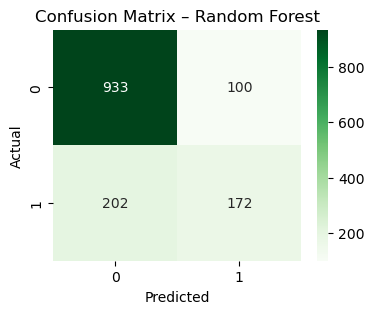

In [54]:

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Note for the team - Remove this before send
END OF RANDOM FOREST MODEL
Add new model before item 10. Compare models

In [55]:
# 10. Compare models

metrics_df = pd.DataFrame(
    [rf_metrics], # add here your results
    columns=["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"],
    index=["Random Forest"] # add here the model name
)

metrics_df


,Accuracy,Precision,Recall,F1,ROC_AUC
Random Forest,0.785359,0.632353,0.459893,0.532508,0.812203


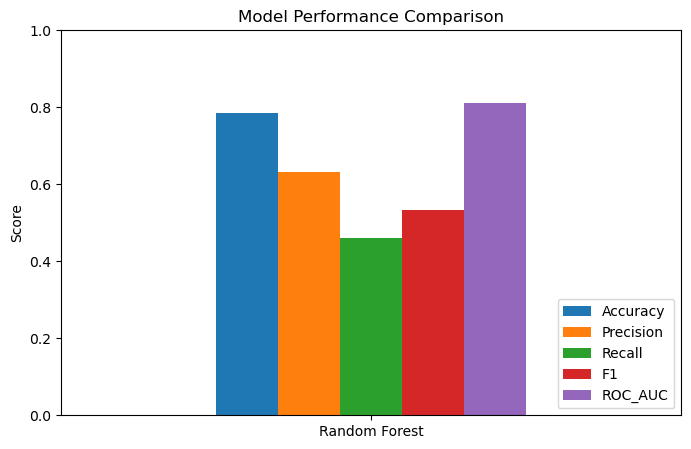

In [56]:
# Simple bar plot comparison

metrics_df.plot(kind="bar", figsize=(8, 5))
plt.title("Model Performance Comparison")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.show()
